# Imports

In [27]:
import json
from __future__ import division
import warnings
warnings.filterwarnings('ignore')
import sys
from numpy.random import randint
from numpy.random import rand
import multiprocessing as mp
import random
import math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map
sys.path.append("./src")
from convertor import convert
import os
from sklearn.preprocessing import OneHotEncoder

In [28]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM,Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,UpSampling1D, Conv1DTranspose,GaussianNoise 
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback
from keras.regularizers import l2 , l1, l1_l2
import tensorflow.keras.backend as kb
print('keras version ', keras.__version__)

from keras.utils.vis_utils import plot_model

keras version  2.9.0


# Functions

In [5]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [6]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [7]:
class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

def confusion_matrix(validations, predictions, LABELS):            
    freq = metrics.confusion_matrix(validations, predictions)        
    sensitivity =  (np.divide(freq.transpose(),
                             np.sum(freq, axis=1)).transpose() * 100).round(2)    
    annotation = []
    for i in range(freq.shape[0]):
        row = []
        for j in range(freq.shape[1]):
            row.append(f'{freq[i][j]}\n {sensitivity[i][j]}%')            
        annotation.append(row)
    annotation = np.array(annotation)
    sns.heatmap(sensitivity, cmap="YlOrBr",
                vmin=0, vmax=100,
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=annotation,
               fmt=':<')    
    plt.title("Confusion Matrix")
    plt.ylabel("Actually Label")
    plt.xlabel("Predicted Label")
    plt.show()            

def report(pred, df, ref):
    number_of_hit = len(df['hit seq'].unique())
    print(f'number of unique hit: {number_of_hit}')
    total = len(df[df['hit seq'].isin(ref['data'])]['hit seq'].unique()) 
    print(f'total mir: {total}')    
    selected = df[pd.Series(pred).apply(lambda x: True if x==1 else False)]
    found_seq = selected[selected['hit seq'].isin(ref['data'])]['hit seq'].unique()
    found = len(found_seq)
    print(f'found mir : {found}')
    print(f'fount to all : {round(found / total * 100, 2)}%')
    fp = len(selected[~selected['hit seq'].isin(ref['data'])]['hit seq'].unique())
    print(f'fp: {fp}')

# Load all mediom dataset

In [9]:
data = {}
data["O.sativa"] = {}
data["C.Sinensis"] = {}
data["A.thaliana"] = {}
data["Z.mays"] = {}

In [10]:
data["O.sativa"]['df'] = pd.read_csv(f"./Experiment/O.sativa/Result/result_level1_filter.csv")
data["O.sativa"]['df'] = convert(data["O.sativa"]['df'])

In [11]:
data["O.sativa"]['reference'] = fasta_to_df(f"./Experiment/O.sativa/reference.fasta")
data["O.sativa"]['reference']['data'] = data["O.sativa"]['reference']['data'].apply(lambda x: x.replace("U", "T"))

In [12]:
data["A.thaliana"]['df'] = pd.read_csv(f"./Experiment/A.thaliana/Result/result_level1_filter.csv")
data["A.thaliana"]['df'] = convert(data["A.thaliana"]['df'] )

In [13]:
data["A.thaliana"]['reference'] = fasta_to_df(f"./Experiment/A.thaliana/reference.fasta")
data["A.thaliana"]['reference']['data'] = data["A.thaliana"]['reference']['data'].apply(lambda x: x.replace("U", "T"))

In [14]:
data["C.Sinensis"]['df'] = pd.read_csv(f"./Experiment/C.Sinensis/Result/result_level1_filter.csv")
data["C.Sinensis"]['df'] = convert(data["C.Sinensis"]['df'])

In [15]:
data["C.Sinensis"]['reference'] = fasta_to_df(f"./Experiment/C.Sinensis/reference.fasta")
data["C.Sinensis"]['reference']['data'] = data["C.Sinensis"]['reference']['data'].apply(lambda x: x.replace("U", "T"))

In [16]:
data["Z.mays"]['df'] = pd.read_csv(f"./Experiment/Z.mays/Result/result_level1_filter.csv")
data["Z.mays"]['df'] = convert(data["Z.mays"]['df'])

In [17]:
data["Z.mays"]['reference'] = fasta_to_df(f"./Experiment/Z.mays/reference.fasta")
data["Z.mays"]['reference']['data'] = data["Z.mays"]['reference']['data'].apply(lambda x: x.replace("U", "T"))

# Preprocess: convert ct-analizer result to feature vector

In [29]:
from preprocessing import get_target, preprocessing

# Apply preprocess

In [20]:
data['O.sativa']['feature'] = preprocessing(data["O.sativa"]['df'])
data['O.sativa']['target'] = get_target(data["O.sativa"]['df'], data["O.sativa"]['reference'])

In [21]:
data['A.thaliana']['feature'] = preprocessing(data["A.thaliana"]['df'])
data['A.thaliana']['target'] = get_target(data["A.thaliana"]['df'], data["A.thaliana"]['reference'])

In [30]:
data['C.Sinensis']['feature'] = preprocessing(data["C.Sinensis"]['df'])
data['C.Sinensis']['target'] = get_target(data["C.Sinensis"]['df'], data["C.Sinensis"]['reference'])

In [31]:
data['Z.mays']['feature'] = preprocessing(data["Z.mays"]['df'])
data['Z.mays']['target'] = get_target(data["Z.mays"]['df'], data["Z.mays"]['reference'])

# Deep learning model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data['O.sativa']['feature'], data['O.sativa']['target'], test_size=0.33, random_state=42)

In [ ]:
class_weight = {0: 1.,
                1: (sum(y_train[:,0]) + sum(y_val[:,0])) / (sum(y_train[:,1]) + sum(y_val[:,1]))}
class_weight

{0: 1.0, 1: 144.69557522123893}

In [ ]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='softmax'))
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 256)               82688     
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_35 (Dense)            (None, 128)               32896     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 16)               

In [ ]:
callbacks_list = [
                  tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=5, restore_best_weights=True),
                 ]
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

model.compile(loss = "categorical_crossentropy",                
                optimizer=optimizer,
                metrics = ["acc"])                
BATCH_SIZE = 64
EPOCHS = 100
history = model.fit(X_train,
                    y_train,
                    class_weight=class_weight,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    verbose=1) 

json.dump(str(history.history), open(f"./history.pkl", "w"))
model.save(f'./Model.h5')

Epoch 1/100
862/862 [==============================] - 7s 7ms/step - loss: 1.3495 - acc: 0.8053 - val_loss: 0.2467 - val_acc: 0.8761
Epoch 2/100
862/862 [==============================] - 5s 6ms/step - loss: 0.7847 - acc: 0.8327 - val_loss: 0.2197 - val_acc: 0.9034
Epoch 3/100
862/862 [==============================] - 5s 6ms/step - loss: 0.7885 - acc: 0.8330 - val_loss: 0.4773 - val_acc: 0.7715
Epoch 4/100
862/862 [==============================] - 6s 7ms/step - loss: 0.6308 - acc: 0.8470 - val_loss: 0.1863 - val_acc: 0.9267
Epoch 5/100
862/862 [==============================] - 5s 6ms/step - loss: 0.5264 - acc: 0.8686 - val_loss: 0.2525 - val_acc: 0.8932
Epoch 6/100
862/862 [==============================] - 5s 6ms/step - loss: 0.5490 - acc: 0.8665 - val_loss: 0.2714 - val_acc: 0.8677
Epoch 7/100
862/862 [==============================] - 6s 7ms/step - loss: 0.4502 - acc: 0.8886 - val_loss: 0.1534 - val_acc: 0.9287
Epoch 8/100
862/862 [==============================] - 6s 7ms/step - 

# O.sativa

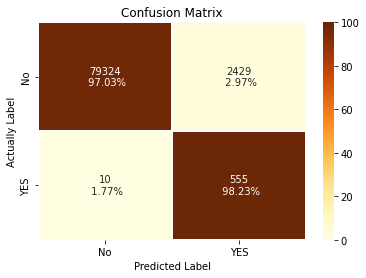

number of unique hit: 11172
total mir: 90
found mir : 89
fount to all : 98.89%
fp: 684
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     81753
           1       0.19      0.98      0.31       565

    accuracy                           0.97     82318
   macro avg       0.59      0.98      0.65     82318
weighted avg       0.99      0.97      0.98     82318



In [ ]:
plant = 'O.sativa'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
report(y_pred, data[plant]['df'], data[plant]['reference'])
print(classification_report(y_true, y_pred))

# A.thaliana

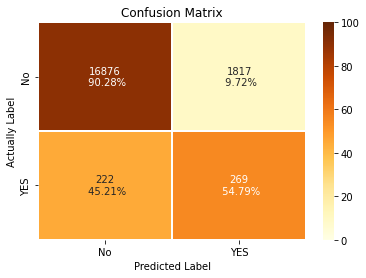

number of unique hit: 3349
total mir: 90
found mir : 55
fount to all : 61.11%
fp: 459
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18693
           1       0.13      0.55      0.21       491

    accuracy                           0.89     19184
   macro avg       0.56      0.73      0.58     19184
weighted avg       0.97      0.89      0.92     19184



In [ ]:
plant = 'A.thaliana'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
report(y_pred, data[plant]['df'], data[plant]['reference'])
print(classification_report(y_true, y_pred))

# C.Sinensis

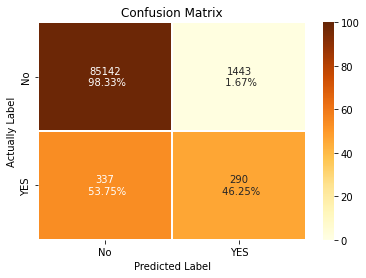

number of unique hit: 6419
total mir: 86
found mir : 46
fount to all : 53.49%
fp: 367
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     86585
           1       0.17      0.46      0.25       627

    accuracy                           0.98     87212
   macro avg       0.58      0.72      0.62     87212
weighted avg       0.99      0.98      0.98     87212



In [ ]:
plant = 'C.Sinensis'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
report(y_pred, data[plant]['df'], data[plant]['reference'])
print(classification_report(y_true, y_pred))

# Z.mays

In [ ]:
plant = 'Z.mays'
y_true = np.argmax(data[plant]['target'], axis=1)
y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
confusion_matrix(y_true,y_pred,["No","YES"])
report(y_pred, data[plant]['df'], data[plant]['reference'])
print(classification_report(y_true, y_pred))